<img src="https://s0.cptec.inpe.br/webcptec/sites/www/assets/img/logo_cptec.png" align="right" width="64"/>

# <div style="text-align: center;"><span style="color:#336699; font-size: 1.2em;">1º Love Data Day - BIG TechTalks:<br><span style="color:#336699; font-style: italic;">      Usando Dados de Precipitação e STAC Browser para Avaliar o "Dia do Fogo em SP"</span></span></div>
<hr style="border:2px solid #0077b9;">

<br/>

<div style="text-align: center;font-size: 90%;">
    Alex de Almeida Fernandes<sup><a href="https://orcid.org/0000-0003-1520-5896"><i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup>
    <br/><br/>
    Divisão de Previsão de Tempo e Clima, Instituto Nacional de Pesquisas Espaciais (INPE)
    <br/>
    Rodovia Presidente Dutra, km 40, Cachoeira Paulista, SP 12630-000, Brazil
    <br/><br/>
    Contato: <a href="mailto:alex.fernandes@inpe.br">alex.fernandes@inpe.br</a>
    <br/><br/>
    Ultíma Atualização: 27 de Maio de 2025
</div>

<br/>

<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;">
<b>Resumo.</b> Este Jupyter Notebook é parte do BIG TechTalks, edição especial <i>Love Data Days</i> - Acesso, Visualização e Processamento de dados de precipitação diária acumulada do dado MERGE produzido no INPE. O dado MERGE consiste na combinação dos dados de superfície das estações em conformidade com o padrão da Organização Meteorológica Mundial e dados de estimativas de precipitação por satélite IMERG/GPM. Esta combinação torna a estimativa de satélite mais precisa e permite o uso em locais onde não há observações de superfície nas proximidades. Este Jupyter Notebook apresenta uma visão geral de como utilizar o serviço STAC na linguagem Python para descoberta e acesso aos produtos de dados de sensoriamento remoto disponíveis no catálogo do INPE, além de demonstrar a abertura de arquivos no formato GRIB2 e como visualizar os dados de precipitação.
<br/><br/>
<b>Referências.</b><br> 
<a href="https://www.tandfonline.com/doi/full/10.1080/01431161.2020.1763504 " target="_blank">Performance of precipitation products obtained from combinations of satellite and surface observations</a>
<a href="https://doi.org/10.3390/rs10060882 " target="_blank">Evaluation of TRMM/GPM Blended Daily Products over Brazil</a>
</div>



# Dia do Fogo em SP - 23 de Agosto de 2024

No dia 23 de agosto de 2024 um evento chamou atenção pública pela ocorrência de diversos focos de fogo iniciando em horários próximos na região norte e oeste do estado de São Paulo.
A intenção deste notebook é demonstrar as _condições de fogo_ baseando-se na precipitação ocorrida até 3 meses antes. 

Os dados de precipitação utilizados será a base do MERGE/INPE, que combina dados observados em superfície com estimativas de satélite, fornecendo um dado mais preciso do que a estimativa pura.

A precipitação ocorrida no perído de 2024 será comparada com a média de longo termo iniciada em 2000, dete modo, teremos uma comparação da quantidade de chuva média em 24 anos e no ano de ocorrência do evento. Será que houve menos chuva nesse período? O solo e a vegetação estavam mais secos e apresentavam condições para que o fogo fosse difícil de controlar? 

Vamos olhar os dados...

In [1]:
%pip install xarray cfgrib netcdf4
%pip install cartopy
%pip install geopandas
%pip install regionmask

#%pip show cartopy
#%pip show cfgrib

%reset -f

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import pystac_client
import pystac
import itertools
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
from dateutil.parser import parse

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['PROJ_LIB'] = "/opt/conda/envs/geospatial/share/proj"


## 1. Serviço STAC e Coleções

Notebook de demonstração de acesso ao catálogo e da coleção de interesse, neste caso o MERGE com acumulado diário de precipitação em formato _GRIB2_.

Boa parte dos produtos de imagem disponibilizados no catálogo de imagens do INPE são disponibilizados de maneira aberta na forma de arquivos otimizados para cloud, o denominado formato Cloud Optimized GeoTIFF (COG). Este formato permite que as aplicações possam utilizar as imagens através da Web com o melhor compromisso possível, incluindo o uso de pirâmide de multi-resolução para aplicações de visualização ou até mesmo a recuperação parcial de porções de uma imagem. O COG e o serviço de análise da BIG/INPE permite várias análises e fecilidades com tal formato, que não será o caso deste notebook. 

Os produtos de dados podem ser consultados utilizando uma interface de programação de aplicações baseada no padrão aberto SpatioTemporal Asset Catalog (STAC). Esta especificação, criada por organizações e especialistas do setor geoespaciall.

Em que:

- **Catalog**: É um tipo de objeto que fornece uma estrutura para vincular vários itens ou coleções STAC juntos ou mesmo outros catálogos. Na figura acima, o catálogo é composto de três coleções: Landsat/OLI, CBERS4/WFI e Sentinel-2/MSI.

- **Collection:** É uma especialização do catálogo que permite incluir informações adicionais sobre uma determinada coleção espaço-temporal. Uma coleção pode conter informações como o conjunto de bandas espectrais disponíveis das imagens, a extensão geográfica ou área de cobertura das imagens, o período de tempo que compreende a coleção, entre outras informações. Em geral, através da coleção chegamos aos itens dessa coleção.

- **Item**: Corresponde à unidade atômica de metadados, fornecendo *links* para os *assets* associados. Um *Item* é descrito através da notação GeoJSON, como uma feição (*feature*) contendo atributos específicos como a coleção a que ele pertence, propriedades temporais, *links* para os *assets* e coleções ou catálogos associados. Na figura acima, um `Item` equivale a uma cena obtida por um satélite em um determinado instante de tempo.

- **Asset**: Um *asset* é qualquer recurso geoespacial, como um arquivo de imagem ou arquivo vetorial, contendo informações sobre a supefície da Terra, em um determinado espaço e tempo.


A especificação conceitual do STAC permite dois tipos de implementações:

- **STAC estático:** Baseada em um conjunto de documentos JSON ligados que podem ser facilmente navegados. Ex: [CBERS na AWS](https://cbers-stac-1-0-0.s3.amazonaws.com/CBERS4/catalog.json).

- **STAC dinâmico:** Baseada em uma API RESTful, de modo que a navegação é realizada através de uma API de serviço web que permite realizar consultas utilizando uma linguagem padrão para acessar subconjuntos do catálogo. Ex: [BDC-STAC](https://data.inpe.br/bdc/stac/v1).


<br/>
<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;font-size: 75%; border-style: solid; border-color: #0077b9; border-width: 1px; padding: 5px;">
    <b>Nota:</b> Como parte do aperfeiçoamento dos produtos e serviços disponibilizados pelo INPE à sociedade, encontra-se em desenvolvimento o novo portal <a href="https://data.inpe.br/">https://data.inpe.br/</a>, que faz parte da modernização da infraestrutura de serviços para acesso às imagens de satélites do acervo do instituto. Esse portal foi criado com o intuito de facilitar a pesquisa e obtenção das imagens disponibilizadas gratuitamente. Esse novo serviço tem como base as tecnologias desenvolvidas no projeto Brazil Data Cube, e está ancorado dentro do Programa Base de Informações Georreferenciadas (BIG) do INPE. Para navegar pelas coleções disponibilizadas no serviço STAC do INPE, utilize a instância do [STAC Browser](https://data.inpe.br/stac/browser/).
</div>



In [3]:
#PySTAC
service = pystac_client.Client.open('https://data.inpe.br/bdc/stac/v1/')
service

<Client id=INPE>

In [4]:
collection = service.get_collection('prec_merge_daily-1')
collection

<CollectionClient id=prec_merge_daily-1>

### Função para baixar e ler uma série de dados do STAC.
Atualmente estão sendo utilizados dados de precipitação do MERGE. Tais dados estão em formato GRIB2 e não podem ser acessados diretamente pelo XARRAY; precisam que seja feito o download e depois a leitura.

Na função _Download_and_read_merge_stac_, usamos a bibliotec _requests_ para fazer o download do link HTTPS;
depois, XARRAY abre todos os arquivos com _open_mfdataset_

Para a função, deve-se passar o serviço do pystac_client que foi aberto, uma data inicial e final e o diretório onde os dados serão baixados.
se a data inicial for igual a final, apenas um dia será baixado.

    Busca, baixa e lê dados MERGE em formato GRIB2 do catálogo STAC do INPE,
    filtrando por um período de datas. 

    Args:
        stac_catalog_url (str): URL do catálogo/item STAC do INPE que contém o MERGE diário.
        start_date (str): Data inicial (formato ISO ou legível, ex: '2024-01-01').
        end_date (str): Data final (formato ISO ou legível, ex: '2024-01-31').
        output_dir (str): Pasta onde salvar os arquivos baixados.

    Returns:
        ds (xarray.Dataset): Dataset final contendo os dados do merge com a dimensão tempo.


In [5]:
def download_and_read_merge_stac(
    stac_service: str,
    start_date: str,
    end_date: str,
    output_dir: str = "merge_data"
):
    """
    Busca, baixa e lê dados MERGE em formato GRIB2 do catálogo STAC do INPE,
    filtrando por um período de datas. 

    Args:
        stac_catalog_url (str): URL do catálogo/item STAC do INPE que contém o MERGE diário.
        start_date (str): Data inicial (formato ISO ou legível, ex: '2024-01-01').
        end_date (str): Data final (formato ISO ou legível, ex: '2024-01-31').
        output_dir (str): Pasta onde salvar os arquivos baixados.

    Returns:
        ds (xarray.Dataset): Dataset final contendo os dados do merge com a dimensão tempo.
    """
    # Converte datas para objetos datetime
    start_dt = parse(start_date)
    end_dt = parse(end_date)

    # Cria diretório de saída se não existir
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True, parents=True)

    downloaded_files = []

    if isinstance(service, pystac.Catalog) and stac_service.id == 'INPE':  # acesso stac server do INPE
        item_search = service.search(datetime=start_date+'/'+end_date,     # Pesquisa apenas as datas de interesse na coleção prec_merge_daily-1
                             collections=['prec_merge_daily-1'])
        for asset in item_search.items():                                  # verifica os assets dos itens encontrados anteriormente
            if asset.assets['merge_daily'].href.endswith(".grib2"):        # Acessa apenas os links dos dados GRIB2, há outros como o idx e ctl.
                file_url = asset.assets['merge_daily'].href
                filename = Path(file_url).name
                file_path = output_path / filename

                #print(f"Baixando: {file_url}")
                response = requests.get(file_url, stream=True)             # Baixa os dados 
                response.raise_for_status()

                with open(file_path, "wb") as f:
                    for chunk in response.iter_content(chunk_size=1024 * 1024):
                        if chunk:
                            f.write(chunk)

                        print(f"Arquivo salvo: {file_path}")
                        downloaded_files.append(file_path)                # Adiciona novo arquivo baixado na lista de arquivos para abertura com o xarray
    else:
        raise ValueError("STAC URL deve apontar para um Catálogo ou Item.")

    # Verifica se algum arquivo foi baixado
    if not downloaded_files:
        raise FileNotFoundError("Nenhum arquivo .grib2 foi encontrado no período especificado.")

    # Lê os arquivos com xarray
    print("Lendo arquivos com xarray...")
          
    # Lê múltiplos arquivos com open_mfdataset, aplicando a função preprocess
    ds = xr.open_mfdataset(
        downloaded_files,
        engine='cfgrib',
        combine='nested',
        concat_dim='time',
        decode_timedelta=False)

    return ds

ds = download_and_read_merge_stac(service, '2024-05-01', '2024-08-31', './data/merge')
ds = ds.sortby('time')  # O download pode não ter ocorrido na ordem de datas, portanto ordena o dado pela dimensão _time_
ds

Arquivo salvo: data/merge/MERGE_CPTEC_20240901.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240831.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240830.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240829.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240828.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240827.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240826.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240825.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240824.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240823.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240822.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240821.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240820.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240819.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240818.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240817.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240816.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240815.grib2
Arquivo salvo: data/merge/MERGE_CPTEC_20240814

<xarray.Dataset> Size: 918MB
Dimensions:     (time: 124, latitude: 924, longitude: 1001)
Coordinates:
  * time        (time) datetime64[ns] 992B 2024-05-01T12:00:00 ... 2024-09-01...
    step        float64 8B 0.0
    surface     float64 8B 2.55e+03
  * latitude    (latitude) float64 7kB -60.05 -59.95 -59.85 ... 32.15 32.25
  * longitude   (longitude) float64 8kB 239.9 240.0 240.1 ... 339.8 339.9 339.9
    valid_time  (time) datetime64[ns] 992B 2024-05-01T12:00:00 ... 2024-09-01...
Data variables:
    rdp         (time, latitude, longitude) float32 459MB dask.array<chunksize=(1, 924, 1001), meta=np.ndarray>
    prmsl       (time, latitude, longitude) float32 459MB dask.array<chunksize=(1, 924, 1001), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             255
    GRIB_centreDescription:  Not to be used
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Not to be used
    history:                 2025-11-13T09:09 GRIB to CDM+CF via cfgrib-0.9.1...

## 2. Plots!!

Vamos ver as chuvas que ocorreram em um período anterior à 3 meses do evento do _Dia do Fogo em SP_.

Chuvas que ocorreram próximas ao _dia do fogo_, podem indicar condições desfavoráveis; quanto mais seca vegetação e o solo, melhores são as condições.

Observações importantes:

- **Chuva**: Consideramos _chuva_ dados acima de 1mm.
- **Chuva fraca**: Será considerado como chuva fraca o limiar menor ou igual à 10mm/dia.
- **MLT**: Média de longo termo, ou a média de 24 anos de dados MERGE
- **Classificação de chuva**: Classificação do acumulado de chuva

<table border="1">
    <tr>
        <th>Classificação</th>
        <th>Precipitação Acumulada (mm/dia)</th>
    </tr>
    <tr>
        <td>Fraca</td>
        <td>0 - 5</td>
    </tr>
    <tr>
        <td>Moderada</td>
        <td>5.1 - 20</td>
    </tr>
    <tr>
        <td>Forte</td>
        <td>20.1 - 50</td>
    </tr>
    <tr>
        <td>Muito Forte</td>
        <td>50.1 - 100</td>
    </tr>
    <tr>
        <td>Extrema</td>
        <td>100+</td>
    </tr>
</table>

Fonte: https://www.portalmultiplix.com/noticias/cotidiano/meteorologista-do-inmet-explica-como-classificar-a-intensidade-das-chuvas

### Função básica para os plots

Função para plotar as imagens, podendo recortar em área, escolher variável, mapa de cores e escala de valores.
Preparada com valores padrão para o MERGE diário, para outros dados deve-se usar os argumentos.

    Usa _XARRAY DATASET_ para plotar.

In [6]:
def plot_precipitacao_merge(
    ds,
    var='rdp',
    title='Precipitação Total (MERGE)',
    cmap='YlGnBu',
    levels=np.linspace(0, 50, 51),
    extent=[-85, -34, -60, 15]  # Extent da América do Sul
):
    """
    Plota a variável de precipitação do dataset MERGE para a América do Sul.

    Args:
        ds (xarray.Dataset): Dataset com os dados lidos (ex: de xr.open_dataset).
        var (str): Nome da variável de precipitação. Padrão: 'tp' (total precipitation).
        title (str): Título do gráfico.
        cmap (str): Colormap usado.
        levels (array): Níveis do contorno para o plot.
        extent (list): [min_lon, max_lon, min_lat, max_lat] da região a ser plotada.
    """
    # Definir projeção
    proj = ccrs.PlateCarree()

    # Criar figura e eixo com projeção geográfica
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': proj})

    # Seleciona a variável e plota
    pcm = ds[var].plot.pcolormesh(
        ax=ax,
        transform=proj,
        cmap=cmap,
        levels=levels,
        extend='max',
        add_colorbar=True,
        cbar_kwargs={'shrink': 0.7, 'label': 'Precipitação (mm/h)'}
    )

    # Configurações do mapa
    ax.set_title(title, fontsize=14)
    ax.set_extent(extent, crs=proj)

    # Adicionar limites continentais e países
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
    ax.add_feature(cfeature.STATES, linewidth=0.3, alpha=0.5)

    # Grid e rótulos
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    plt.tight_layout()
    plt.show()

### Exemplo de uso da função para plotar dados.

Primeiro uma imagem da América do Sul e depois repassando apenas o intervalo de interesse, Estado de São Paulo.

<xarray.Dataset> Size: 7MB
Dimensions:    (latitude: 924, longitude: 1001)
Coordinates:
    step       float64 8B 0.0
    surface    float64 8B 2.55e+03
  * latitude   (latitude) float64 7kB -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude  (longitude) float64 8kB 239.9 240.0 240.1 ... 339.8 339.9 339.9
Data variables:
    rdp        (latitude, longitude) float32 4MB dask.array<chunksize=(924, 1001), meta=np.ndarray>
    prmsl      (latitude, longitude) float32 4MB dask.array<chunksize=(924, 1001), meta=np.ndarray>


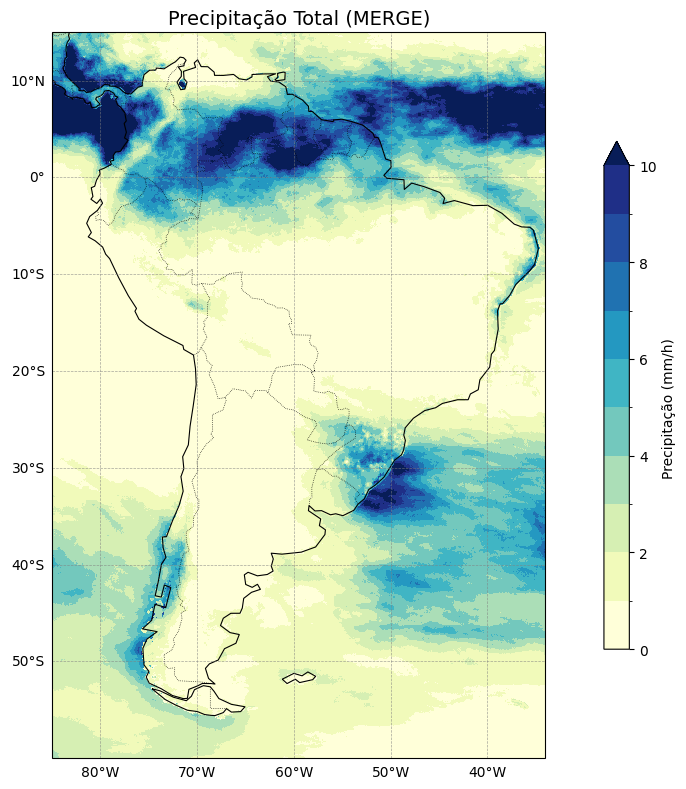

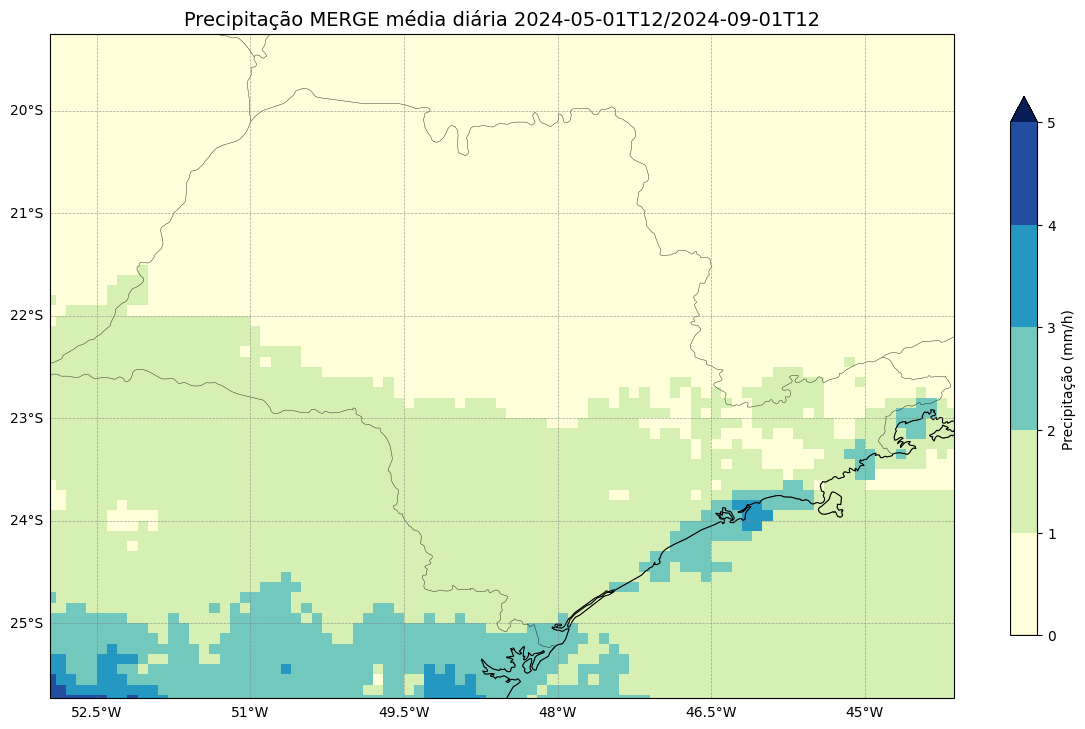

In [7]:
dy = ds.mean(dim='time')
print(dy)

plot_precipitacao_merge(dy, levels=np.linspace(0, 10, 11))
plot_precipitacao_merge(ds.mean(dim='time'), 
                        extent=[-52.9518,-44.1291,-25.7323,-19.2479], 
                        levels=np.linspace(0, 5, 6),
                        title='Precipitação MERGE média diária '+str(ds.time.min().values)[0:13]+'/'+str(ds.time.max().values)[0:13]
                       )


### Função para recortar o Datase 

Recorta os dados apenas na região de interesse visando um local onde houveram mais focos.
Utilizada _sel_ do XARRAY para realizar os recortes.

In [8]:
def recortar_dataset_por_regiao(ds, lon_min, lon_max, lat_min, lat_max):
    """
    Recorta o dataset ou dataArray para uma região retangular definida por lat/lon.

    Args:
        ds (xarray.Dataset or xarray.DataArray): O dataset ou array a ser recortado.
        lon_min (float): Longitude mínima da região.
        lon_max (float): Longitude máxima da região.
        lat_min (float): Latitude mínima da região.
        lat_max (float): Latitude máxima da região.

    Returns:
        xarray.Dataset or xarray.DataArray: Dataset/DataArray recortado para a região especificada.
    """
    # Verifica se as dimensões estão corretas
    if 'latitude' in ds.dims and 'longitude' in ds.dims:
        # Aplica o recorte
        recortado = ds.sel(
            longitude=slice(360+lon_min, 360+lon_max),
            latitude=slice(lat_min,lat_max)  # Ordem decrescente em latitude é comum em datasets
        )
    elif 'lat' in ds.dims and 'lon' in ds.dims:
        # Aplica o recorte
        recortado = ds.sel(
            lon=slice(lon_min, lon_max),
            lat=slice(lat_min,lat_max)  # Ordem decrescente em latitude é comum em datasets
    )
        
    else:
        raise ValueError("O dataset deve conter as dimensões 'latitude' e 'longitude'.")


    return recortado

### Dados recortados ds_sp

In [9]:
# Aplicar máscara
#ds_sp = mask_sp_dataset_ibge_2024(ds)
ds_sp = recortar_dataset_por_regiao(ds, -52.9518,-45.2291,-22,-19.2479)
ds_sp



<xarray.Dataset> Size: 2MB
Dimensions:     (time: 124, latitude: 28, longitude: 78)
Coordinates:
  * time        (time) datetime64[ns] 992B 2024-05-01T12:00:00 ... 2024-09-01...
    step        float64 8B 0.0
    surface     float64 8B 2.55e+03
  * latitude    (latitude) float64 224B -21.95 -21.85 -21.75 ... -19.35 -19.25
  * longitude   (longitude) float64 624B 307.1 307.2 307.3 ... 314.6 314.7 314.8
    valid_time  (time) datetime64[ns] 992B 2024-05-01T12:00:00 ... 2024-09-01...
Data variables:
    rdp         (time, latitude, longitude) float32 1MB dask.array<chunksize=(1, 28, 78), meta=np.ndarray>
    prmsl       (time, latitude, longitude) float32 1MB dask.array<chunksize=(1, 28, 78), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             255
    GRIB_centreDescription:  Not to be used
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Not to be used
    history:                 2025-11-13T09:09 GRIB to CDM+CF via cfgrib-0.9.1...

In [10]:
#plot_precipitacao_merge(ds_sp.mean(dim='time'), 
#                        extent=[-53.9518,-44.1291,-23.7323,-18.2479], 
#                        levels=np.linspace(0, 2, 21),
#                        cmap = 'RdBu')
#
#ds_sp['rdp'].max(axis=[1,2]).plot(figsize=(12, 5))
#plt.show()


### Verificação da precipitação no estado de São Paulo

A linha vermelha indica os valores máximos de precipitação que ocorreram na região de interesse.
As colunas azuis indicam a precipitação máxima quando a média na região do recorte foi maior que 1mm.

Esse filtro na precipitação foi colocado com limiar de 1mm por considerarmos chuva abaixo de 1mm como _não chuva_ em comparações numéricas com dados de estimativas de satélite.

**Identificamos chuva no dia 10/08 e dia 25-26/08**


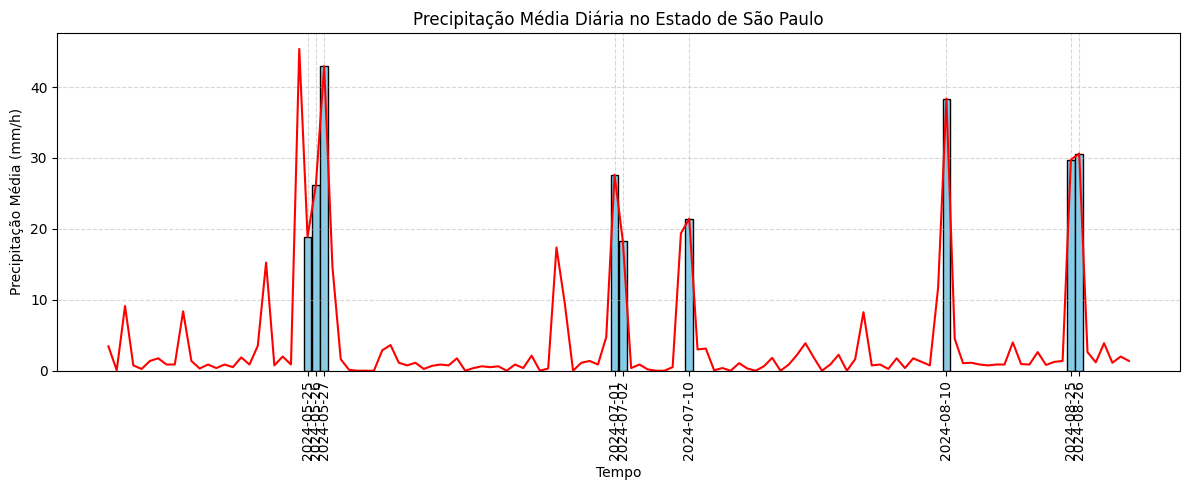

In [11]:
dt = ds_sp['time'][ds_sp['rdp'].mean(axis=[1,2]).values > 1]
tp = ds_sp['rdp'][ds_sp['rdp'].mean(axis=[1,2]).values > 1].max(axis=[1,2])

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(dt, tp, width=0.9, color='skyblue', edgecolor='black')   #
ax.plot(ds_sp['time'],ds_sp['rdp'].max(axis=[1,2]), color='red')
# Mostrar todas as datas
dates = pd.to_datetime(dt.values)
formatted_labels = dates.strftime('%Y-%m-%d')
ax.set_xticks(dt)  # Força todos os ticks
ax.set_xticklabels(formatted_labels, rotation=90)

ax.set_xlabel('Tempo')
ax.set_ylabel('Precipitação Média (mm/h)')
ax.set_title('Precipitação Média Diária no Estado de São Paulo')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

---
Dia 10/08 é relativamente próximo temporalmente do evento do dia do fogo em SP.
Deste modo, resolvemos plotar o dia 10/08 para ver como foi a distribuição da chuva no retângulo de interesse.

Neste caso, o acumulado de chuva que não foi tão expressivo, foi localizado principalmente ao sul de nossa região.

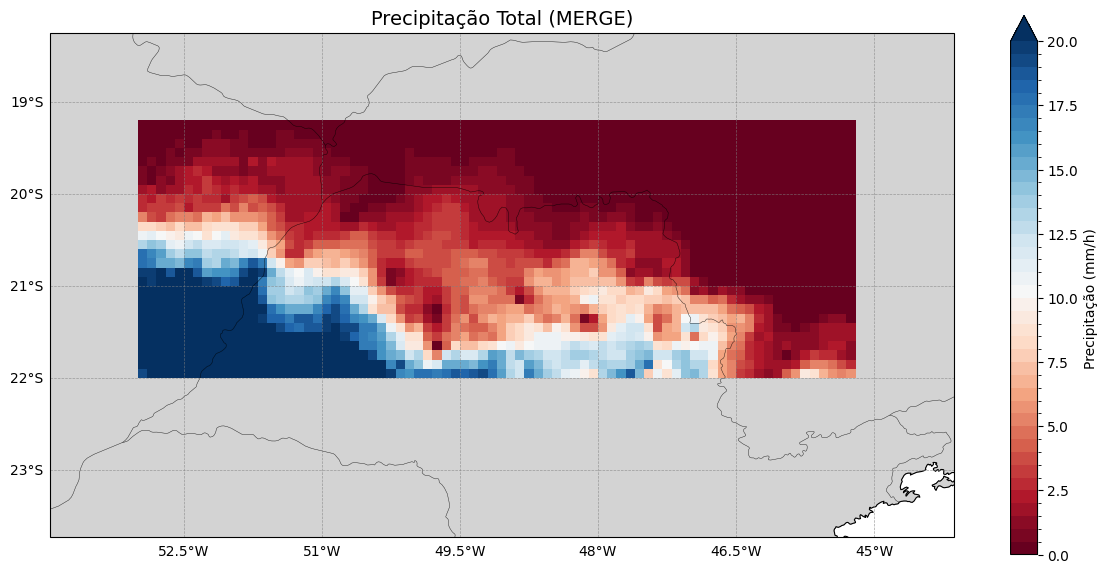

In [12]:
plot_precipitacao_merge(ds_sp.sel(time='2024-08-10').mean(dim='time'), 
                        extent=[-53.9518,-44.1291,-23.7323,-18.2479], 
                        levels=np.linspace(0, 20, 41),
                        cmap = 'RdBu')


### Climatologia

Não sabemos se esta quantidade de chuva é normal para o período e região, deste modo, devemos plotar a média de longo termo dos dados.
Para isso, usaremos a média de 24 anos do MERGE diário; este dado já está calculado e em um diretório HTTPS ainda não cadastrado no STAC:

https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE

Novamente, vamos usar nossa função para download e leitura dos dados. Agora em NetCDF.
A função foi levemente modificada para ler NetCDF e o diretório dos dados sem utilizar o STAC.

In [13]:
def download_mlt_precipitation_data(
    start_date='2024-05-01',
    end_date='2024-08-31',
    output_dir='mlt_data'
):
    """
    Baixa e carrega dados MERGE-LT de precipitação entre duas datas, usando o formato %d%b no nome do arquivo.

    Args:
        start_date (str): Data inicial (formato 'YYYY-MM-DD').
        end_date (str): Data final (formato 'YYYY-MM-DD').
        output_dir (str): Pasta local para salvar os arquivos baixados.

    Returns:
        ds (xarray.Dataset): Dataset com todos os dados concatenados.
    """
    # Criar pasta de saída se não existir
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True, parents=True)

    # Gerar lista de datas
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    downloaded_files = []

    for dt in date_range:
        # Formato dia + mês abreviado em minúsculo (ex: '01jun', '31ago')
        day_month = dt.strftime('%d%b').lower()  # '29Mar' -> '29mar'

        filename = f"MERGE_CPTEC_12Z{day_month}.nc"
        file_url = f"https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/{filename}"

        file_path = output_path / filename

        print(f"Baixando: {file_url}")

        response = requests.get(file_url, stream=True)

        if response.status_code == 200:
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024 * 1024):
                    if chunk:
                        f.write(chunk)
            downloaded_files.append(file_path)
        else:
            print(f"Arquivo não encontrado: {file_url}")

    if not downloaded_files:
        raise FileNotFoundError("Nenhum arquivo foi baixado.")

    print(f"{len(downloaded_files)} arquivos baixados. Carregando com xarray...")

    # Abrir múltiplos arquivos com xarray
    ds = xr.open_mfdataset(
        downloaded_files,
        combine='by_coords'
    )

    return ds

In [14]:
ds_mlt = download_mlt_precipitation_data(output_dir='data/mlt')

Baixando: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/MERGE_CPTEC_12Z01may.nc
Baixando: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/MERGE_CPTEC_12Z02may.nc
Baixando: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/MERGE_CPTEC_12Z03may.nc
Baixando: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/MERGE_CPTEC_12Z04may.nc
Baixando: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/MERGE_CPTEC_12Z05may.nc
Baixando: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/MERGE_CPTEC_12Z06may.nc
Baixando: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/MERGE_CPTEC_12Z07may.nc
Baixando: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/MERGE_CPTEC_12Z08may.nc
Baixando: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/MERGE_CPTEC_12Z09may.nc
Baixando: 

In [15]:
ds_mlt


<xarray.Dataset> Size: 375MB
Dimensions:  (time: 123, lat: 691, lon: 551)
Coordinates:
  * lon      (lon) float64 4kB -85.05 -84.95 -84.85 ... -30.25 -30.15 -30.05
  * lat      (lat) float64 6kB -56.15 -56.05 -55.95 -55.85 ... 12.65 12.75 12.85
  * time     (time) datetime64[ns] 984B 2020-05-01T12:00:00 ... 2020-08-31T12...
Data variables:
    pmed     (time, lat, lon) float64 375MB dask.array<chunksize=(1, 691, 551), meta=np.ndarray>

## 3. Comparação Perído e MLT

### Comparação visual

Primeiro vamos comparar a média espacial da MLT e do período. Qual será o mais seco?
Depois o dia 10/08 na MLT.

Essa comparação visual permite vermos que o período em questão foi mais seco que o normal. E em relação ao dia 10, como será a distribuição dessa chuva temporalmente?


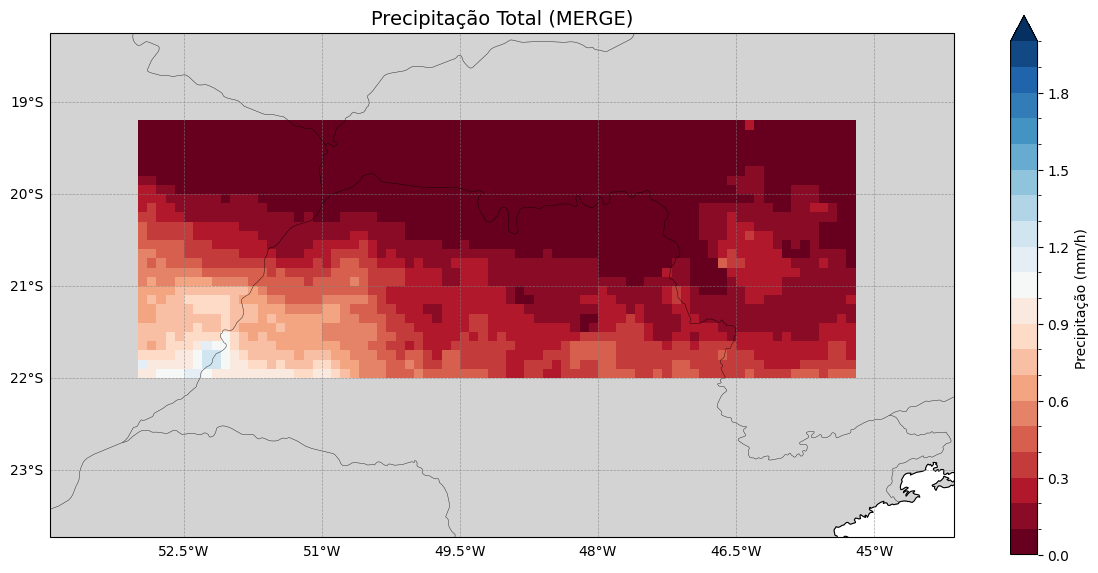

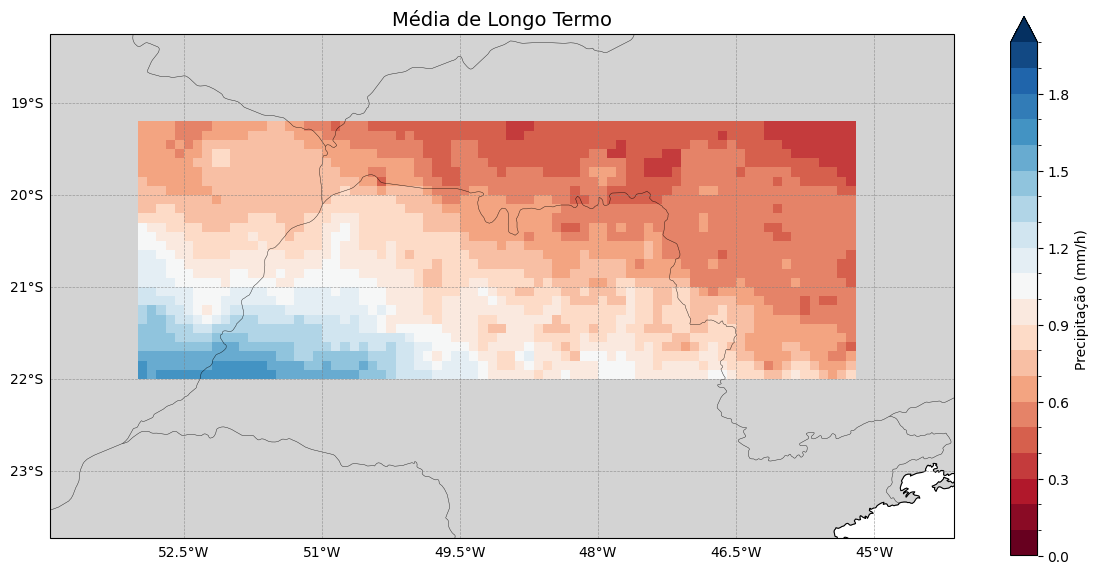

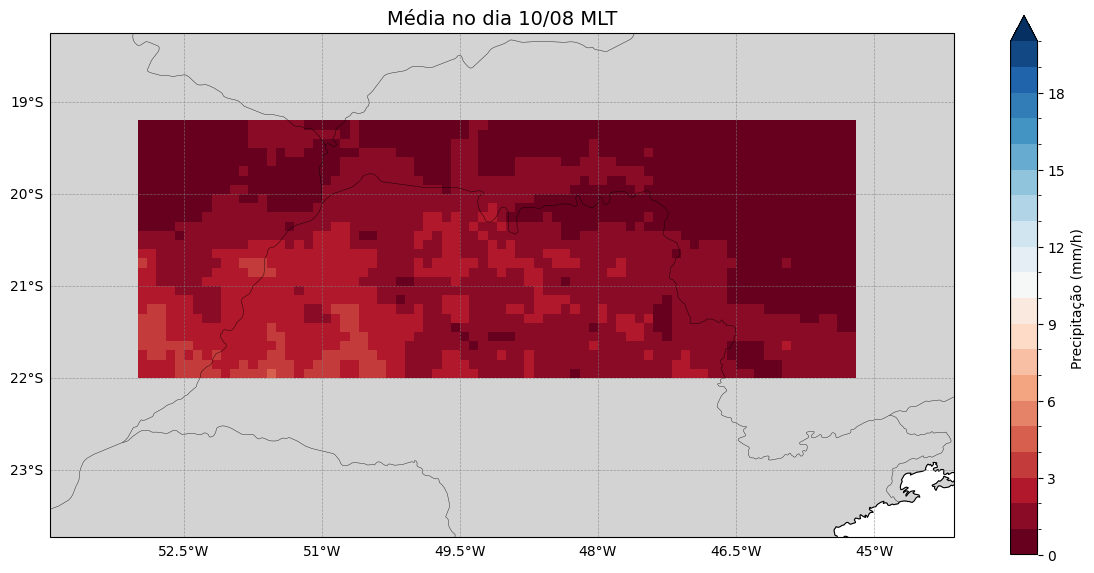

In [16]:
ds_sp_mlt = recortar_dataset_por_regiao(ds_mlt, -52.9518,-45.2291,-22,-19.2479)

plot_precipitacao_merge(ds_sp.mean(dim=['time']), 
                        extent=[-53.9518,-44.1291,-23.7323,-18.2479], 
                        levels=np.linspace(0, 2, 21),
                        cmap = 'RdBu')

plot_precipitacao_merge(ds_sp_mlt.mean(dim=['time']), 
                        extent=[-53.9518,-44.1291,-23.7323,-18.2479], 
                        levels=np.linspace(0, 2, 21),
                        var='pmed',
                        cmap = 'RdBu',
                        title='Média de Longo Termo')

plot_precipitacao_merge(ds_sp_mlt.sel(time='2020-08-10').mean(dim='time'), 
                        extent=[-53.9518,-44.1291,-23.7323,-18.2479], 
                        levels=np.linspace(0, 20, 21),
                        var='pmed',
                        cmap = 'RdBu',
                        title='Média no dia 10/08 MLT')


### Comparação média diária MLT e o _Dia do Fogo_

No gráfico abaixo, colunas vermelhas são a climatologia, a média de 24 anos do MERGE.
As colunas azuis são as precipitações observadas para a média do retângulo no intervalo temporal de interesse.

Vemos que o mês de maio foi um mês completamente diferente da média, sendo muito mais seco que o normal.

Talvez estas sejam condições (parciais) para o fogo...

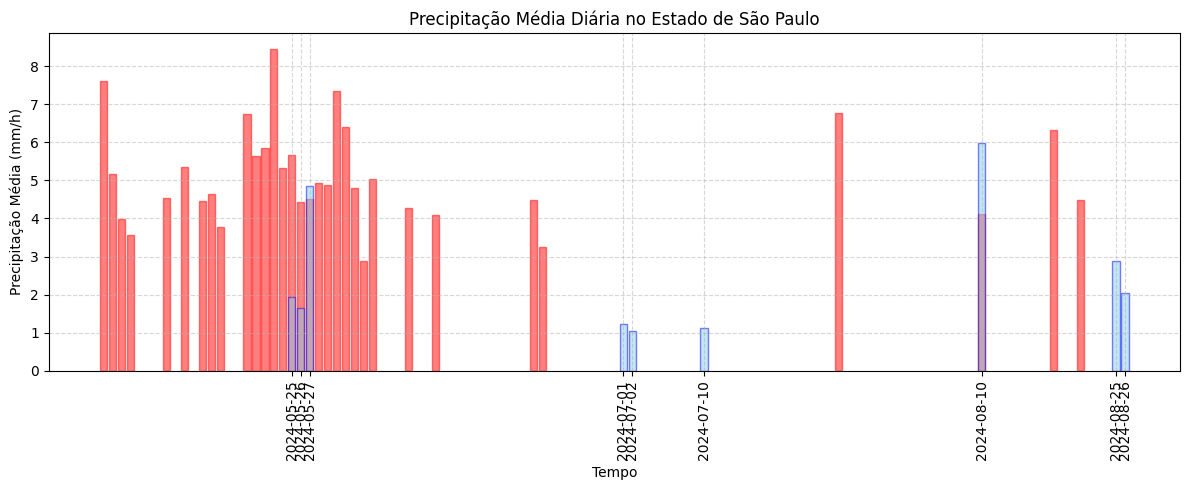

In [17]:
dt = ds_sp['time'][ds_sp['rdp'].mean(axis=[1,2]).values > 1]
tp = ds_sp['rdp'][ds_sp['rdp'].mean(axis=[1,2]).values > 1].mean(axis=[1,2])

dt2 = ds_sp['time'][:123][ds_sp_mlt['pmed'].mean(axis=[1,2]).values > 1]
tp2 = ds_sp_mlt['pmed'][ds_sp_mlt['pmed'].mean(axis=[1,2]).values > 1].max(axis=[1,2])

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(dt2, tp2, width=0.8, color='red', edgecolor='red', alpha=0.5)
ax.bar(dt, tp, width=0.8, color='skyblue', edgecolor='blue', alpha=0.5)

# Mostrar todas as datas
dates = pd.to_datetime(dt.values)
formatted_labels = dates.strftime('%Y-%m-%d')
ax.set_xticks(dt)  # Força todos os ticks
ax.set_xticklabels(formatted_labels, rotation=90)

ax.set_xlabel('Tempo')
ax.set_ylabel('Precipitação Média (mm/h)')
ax.set_title('Precipitação Média Diária no Estado de São Paulo')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
